In [8]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
from pylab import savefig
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import skimage.morphology as morph
from scipy.ndimage.measurements import label

In [43]:
n="5_0.11"
reconstruction = np.load("./{}_reconstruction.npy".format(n))
features = np.load("./{}_features.npy".format(n))

<AxesSubplot:>

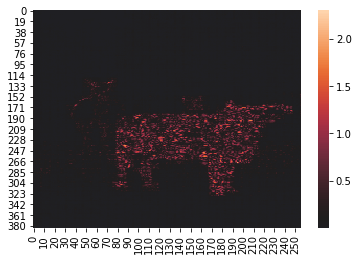

In [44]:
error = np.abs(features-reconstruction)
error = np.sum(error, axis=-1)
mean = np.mean(error)
sns.heatmap(error, center=mean)

In [26]:
res = []
for k in range(0, 30, 1):
    n="5_{}".format(k/100)
    reconstruction = np.load("./{}_reconstruction.npy".format(n))
    features = np.load("./{}_features.npy".format(n))

    error = np.abs(features-reconstruction)
    error = np.sum(error, axis=-1)
    error_list = []

    # K-means
    n, m = error.shape

    for i in range(n):
        for j in range(m):
            error_list.append([error[i, j]])      

    kmeans = KMeans(n_clusters=5, random_state=0).fit(error_list)
    counts = [0, 0, 0, 0, 0]
    #Count k-means class
    for e in kmeans.labels_:
        counts[e] += 1

    error_2 = np.zeros((n, m))
    count = 0
    for i in range(n):
        for j in range(m):
            classe = kmeans.labels_[count]
            if classe != np.argmax(counts):
                if classe == 2:
                    error_2[i,j] = 1
                elif classe == 3:
                    error_2[i,j] = 1

            count += 1

    # Morphology
    closing = morph.binary_closing(error_2, morph.square(4))
    opening = morph.binary_opening(closing, morph.square(4))

    # CC
    labeled_array, num_features = label(opening)

    count = [0 for _ in range(num_features)]
    for i in range(n):
        for j in range(m):
            lab = labeled_array[i, j]
            if lab != 0:
                count[lab - 1] += 1

    # take biggest cc
    error_final = np.zeros(error.shape)
    for i in range(n):
        for j in range(m):
            if labeled_array[i, j] == np.argmax(count) + 1:
                error_final[i, j] = 1

    closing_2 = morph.binary_closing(error_final, morph.square(15))
    dilatation = morph.binary_dilation(closing_2)
    res.append(dilatation)

In [37]:
mask = plt.imread("5_gt.png")
n, m, _ = mask.shape
mask2 = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        if mask[i,j,0] == 1:
            mask2[i, j] = 1
mask = mask2

In [38]:
def dice(pred_mask, mask):
    n, m = mask.shape
    count_pred, count_ori = 0, 0
    inter = 0
    for i in range(n):
        for j in range(m):
            pred = pred_mask[i, j]
            ori = mask[i, j]
            
            count_pred += pred
            count_ori += ori
            
            if pred and ori:
                inter += 1
    return 2*inter/(count_pred+count_ori)

In [39]:
dice_values = []
for pred_mask in res:
    dice_values.append(dice(pred_mask, mask2))

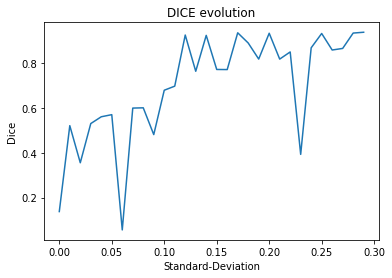

In [46]:
noise = [sig/100 for sig in range(0, 30, 1)]
plt.plot(noise, dice_values)
plt.title("DICE evolution")
plt.xlabel("Standard-Deviation")
plt.ylabel("Dice")
plt.savefig("./cow_curve.jpg", format='jpg')